# Objectives {.unnumbered}

1. Use **PySpark** to process the Lightcast dataset.
2. Engineer features from structured columns for salary prediction.
3. Train **Linear Regression model**.
4. Evaluate models using **RMSE** and **R²**.
5. Visualize predictions using diagnostic plots.
6. Push work to GitHub and submit the repository link.

# Setup {.unnumbered}

The instruction below provides you with general keywords for columns used in the lightcast file. See the data schema generated after the load dataset code above to use proper column name. For visualizations, tables, or summaries, please **customize colors, fonts, and styles** as appropriate to avoid a **2.5-point deduction**. Also, **provide a two-sentence explanation** describing key insights drawn from each section's code and outputs. 

1. Follow the steps below as necessary, use your best judgement in importing/installing/creating/saving files as needed.
2. Create a new Jupyter Notebook in your `ad688-sp25-lab08` directory named `lab08_yourname.ipynb`, if the file exists make sure to change the name.
3. Use your **EC2 instance** for this lab.
4. Ensure the `lightcast_data.csv` file is available on the EC2 instance. if not then **Download the dataset**
5. **Add the dataset to `.gitignore`** to avoid pushing large files to GitHub. Open your `.gitignore` file and add:
6. Make sure to create a virtual environment and install the required Python libraries if needed, don't forget to activate it:
7. Install the required Python libraries if needed, you can also use the given requirement file to install the packages to the virtual environment:

```bash
python3 -m venv .venv
source .venv/bin/activate
gdown https://drive.google.com/uc?id=1V2GCHGt2dkFGqVBeoUFckU4IhUgk4ocQ
echo "lightcast_job_postings.csv" >> .gitignore
pip install -r requirements.txt
```


# Load the Dataset
1. **Load the Raw Dataset**:
   - Use Pyspark to the `lightcast_data.csv` file into a DataFrame:
   - You can reuse the previous code. 
   - [Copying code from your friend constitutes plagiarism. DO NOT DO THIS]{.uured-bold}.


In [ ]:
#| eval: true
#| echo: true
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook"

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("./data/lightcast_job_postings.csv")

# df.printSchema()
# df.show(5)

# Feature Engineering

Feature Engineering is a crucial step in preparing your data for machine learning. In this lab, we will focus on the following tasks:

1. **Drop rows with missing values** in the target variable and key features.
2. By now you are already familiar with the code and the data. Based on your understanding please choose any 3 (my code output has 10) variables as:
   1. two continuous variables (use your best judgment!)
   2. one categorical.
   3. Your dependent variable (y) is `SALARY`.
3. **Convert categorical variables** into numerical representations using **StringIndexer** and **OneHotEncoder**.
4. **Assemble features** into a single vector using **VectorAssembler**.
5. **Split the data** into training and testing sets.


In [ ]:
#| eval: false
#| echo: true
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

df = df.dropna(subset=['DURATION', 'MIN_YEARS_EXPERIENCE', 'EMPLOYMENT_TYPE_NAME', 'SALARY'])

categorical_col = ['EMPLOYMENT_TYPE_NAME']
continuous_cols = ['DURATION', 'MIN_YEARS_EXPERIENCE']

indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid='skip') for col in categorical_col]
encoders = [OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_vec") for col in categorical_col]

assembler = VectorAssembler(
    inputCols=continuous_cols + [f"{col}_vec" for col in categorical_col],
    outputCol='features'
)

pipeline = Pipeline(stages=indexers + encoders + [assembler])
data = pipeline.fit(df).transform(df)

data.select('SALARY', 'features').show(5, False)

+------+-------------------+
|SALARY|features           |
+------+-------------------+
|192800|[55.0,6.0,1.0,0.0] |
|125900|[18.0,12.0,1.0,0.0]|
|118560|[20.0,5.0,1.0,0.0] |
|192800|[55.0,6.0,1.0,0.0] |
|116500|[16.0,12.0,1.0,0.0]|
+------+-------------------+
only showing top 5 rows



# Train/Test Split

- Perform a **random split** of the data into training and testing sets.
- Set a random seed for reproducibility.
- You can choose a number for splitting to your liking, justify your choice.


In [ ]:
#| eval: true
#| echo: false
data = data.select('SALARY', 'features')
train_data, test_data = data.randomSplit([0.8, 0.2], seed=688)
print((train_data.count(), len(train_data.columns)))
print((test_data.count(), len(test_data.columns)))

(11565, 2)


(2853, 2)


# Linear Regression

- Train a **Linear Regression** model using the training data. [You will run in to an important issue here. Please make an effort in figuring it by yourself. This is one of the most asked interview questions in CapitalOne's management recruiting program.]{.uured-bold}
- Evaluate the model on the test data.
- Print the coefficients, intercept, R², RMSE, and MAE.
- Use the `summary` object to extract the coefficients and their standard errors, t-values, and p-values.
- Create a DataFrame to display the coefficients, standard errors, t-values, p-values, and confidence intervals.
- Interpret the coefficients and their significance and explain the model performance metrics.


In [ ]:
#| eval: false
#| echo: false
from pyspark.ml.regression import LinearRegression

train_data = train_data.withColumn('SALARY', col('SALARY').cast("double"))
test_data = test_data.withColumn('SALARY', col('SALARY').cast("double"))

feature_names = assembler.getInputCols()

lr = LinearRegression(featuresCol='features', labelCol='SALARY', regParam=0.1)
lr_model = lr.fit(train_data)
summary = lr_model.summary

test_results = lr_model.evaluate(test_data)

In [ ]:
# Coefficients and Intercept
print("Intercept: {:.4f}".format(lr_model.intercept))
print("Coefficients:")
for i, coef in enumerate(lr_model.coefficients):
     print(f"  Feature {i + 1}: {coef:.4f}")

Intercept: 83756.4100
Coefficients:
  Feature 1: -34.9407
  Feature 2: 6793.7588
  Feature 3: -75.3839
  Feature 4: -1382.5611


In [ ]:
# Model Evaluation
print("R² on test data: {:.4f}".format(test_results.r2))
print("RMSE on test data: {:.4f}".format(test_results.rootMeanSquaredError))
print("MAE on test data: {:.4f}".format(test_results.meanAbsoluteError))

R² on test data: 0.2649
RMSE on test data: 36687.7355
MAE on test data: 28336.4387


In [ ]:
# Print the coefficient table
import pandas as pd
from tabulate import tabulate

coefs = [lr_model.intercept] + list(lr_model.coefficients)
se = list(summary.coefficientStandardErrors)
tvals = list(summary.tValues)
pvals = list(summary.pValues)
ci_low = [c - 1.96 * s for c, s in zip(coefs, se)]
ci_high = [c + 1.96 * s for c, s in zip(coefs, se)]

features = ["Intercept"] +  [f"Feature_{i}" for i in range(1, len(coefs))]
# print("---This is Diagnostic check, No need to print it in the final doc---")
# print("Length of features:", len(features))
# print("Length of coefs:", len(coefs))
# print("Length of se:", len(se))
# print("Length of tvals:", len(tvals))
# print("Length of pvals:", len(pvals))

coef_table = pd.DataFrame({
    "Feature": features,
    "Estimate": [f"{c:.4f}" for c in coefs],
    "Std Error": [f"{s:.4f}" for s in se],
    "t-stat": [f"{t:.4f}" for t in tvals],
    "P-Value": [f"{p:.4f}" for p in pvals],
    "CI Lower": [f"{cl:.4f}" for cl in ci_low],
    "CI Upper": [f"{ch:.4f}" for ch in ci_high]
})

print(tabulate(coef_table, headers="keys", tablefmt="pretty"))

+---+-----------+------------+-----------+---------+---------+------------+------------+
|   |  Feature  |  Estimate  | Std Error | t-stat  | P-Value |  CI Lower  |  CI Upper  |
+---+-----------+------------+-----------+---------+---------+------------+------------+
| 0 | Intercept | 83756.4100 |  23.3778  | -1.4946 | 0.1350  | 83710.5894 | 83802.2305 |
| 1 | Feature_1 |  -34.9407  | 101.3466  | 67.0349 | 0.0000  | -233.5801  |  163.6986  |
| 2 | Feature_2 | 6793.7588  | 2917.7812 | -0.0258 | 0.9794  | 1074.9076  | 12512.6099 |
| 3 | Feature_3 |  -75.3839  | 3485.6145 | -0.3966 | 0.6916  | -6907.1884 | 6756.4206  |
| 4 | Feature_4 | -1382.5611 | 2950.7681 | 28.3846 | 0.0000  | -7166.0665 | 4400.9443  |
+---+-----------+------------+-----------+---------+---------+------------+------------+


The `Intercept` is the baseline salary when all features are zero. Not statistically significant (p > 0.05), so we can't say it differs from zero with confidence. Feature 1 `DURATION` is significant (p < 0.05). All else being equal, each additional day a job posting is posted is associated with a pay reduction of approximately $34. Feature 2 `MIN_YEARS_EXPERIENCE` is not significant (p >> 0.05). While the 1-year increase shows a predicted salary increase of approximately $6.8K, we cannot trust this effect statistically. Feature 3 `Full-time employment` is not significant, which implies nearly no effect of being full-time vs. reference category (mix type). Feature 4 `Part-time employment` is significant. Part-time jobs pay about $1.38K less than the reference category, suggesting a strong and statistically reliable difference.

The `R-Squared` of this model shows that it explains about 26.5% of the variance in salary. This is modest, suggesting other important predictors are missing or salary is inherently noisy. The `RMSE` shows that, on average, the model’s predictions are off by around $36.7K. This is relatively high, depending on the salary scale of your dataset. The `MAE` value shows that the average absolute difference between predicted and actual salaries is about $28.3K, indicating substantial prediction error.

## Generalized Linear Regression Summary
The summary of the Generalized Linear Regression model provides important insights into the model's performance and the significance of each feature. The coefficients indicate the relationship between each feature and the target variable (salary), while the standard errors, t-values, and p-values help assess the reliability of these estimates.

- Please interpret them in the context of your data and model. 
- Feature Names are purposefully not printed in the output. You can use the `features` variable to print them out.


In [ ]:
#| eval: true
#| echo: false

pipeline_model = pipeline.fit(df)
indexer_model = pipeline_model.stages[0]
categories = indexer_model.labels

encoded_categories = categories[:-1]
encoded_feature_names = [f"{categorical_col[0]}={cat}" for cat in encoded_categories]
feature_names = ['Intercept'] + continuous_cols + encoded_feature_names

coef_table_2 = pd.DataFrame({
    "Feature": feature_names,
    "Estimate": [f"{c:.4f}" for c in coefs],
    "Std Error": [f"{s:.4f}" for s in se],
    "t-stat": [f"{t:.4f}" for t in tvals],
    "P-Value": [f"{p:.4f}" for p in pvals]
})

print(tabulate(coef_table_2, headers="keys", tablefmt="pretty"))
coef_table_2.to_csv("_output/lr_summary_pretty.csv", index=False)

+---+---------------------------------------------+------------+-----------+---------+---------+
|   |                   Feature                   |  Estimate  | Std Error | t-stat  | P-Value |
+---+---------------------------------------------+------------+-----------+---------+---------+
| 0 |                  Intercept                  | 83756.4100 |  23.3778  | -1.4946 | 0.1350  |
| 1 |                  DURATION                   |  -34.9407  | 101.3466  | 67.0349 | 0.0000  |
| 2 |            MIN_YEARS_EXPERIENCE             | 6793.7588  | 2917.7812 | -0.0258 | 0.9794  |
| 3 | EMPLOYMENT_TYPE_NAME=Full-time (> 32 hours) |  -75.3839  | 3485.6145 | -0.3966 | 0.6916  |
| 4 | EMPLOYMENT_TYPE_NAME=Part-time (≤ 32 hours) | -1382.5611 | 2950.7681 | 28.3846 | 0.0000  |
+---+---------------------------------------------+------------+-----------+---------+---------+


# Diagnostic Plot

Diagnostic plots are essential for evaluating the performance of regression models. In this section, we will create several diagnostic plots to assess the linear regression model's assumptions and performance. There are four (2*2 grid) main plots we will create, you can use `seaborn` or `matplotlib` for this:

1. **Predicted vs Actual Plot**
2. **Residuals vs Predicted Plot**
3. **Histogram of Residuals**
4. **QQ Plot of Residuals**


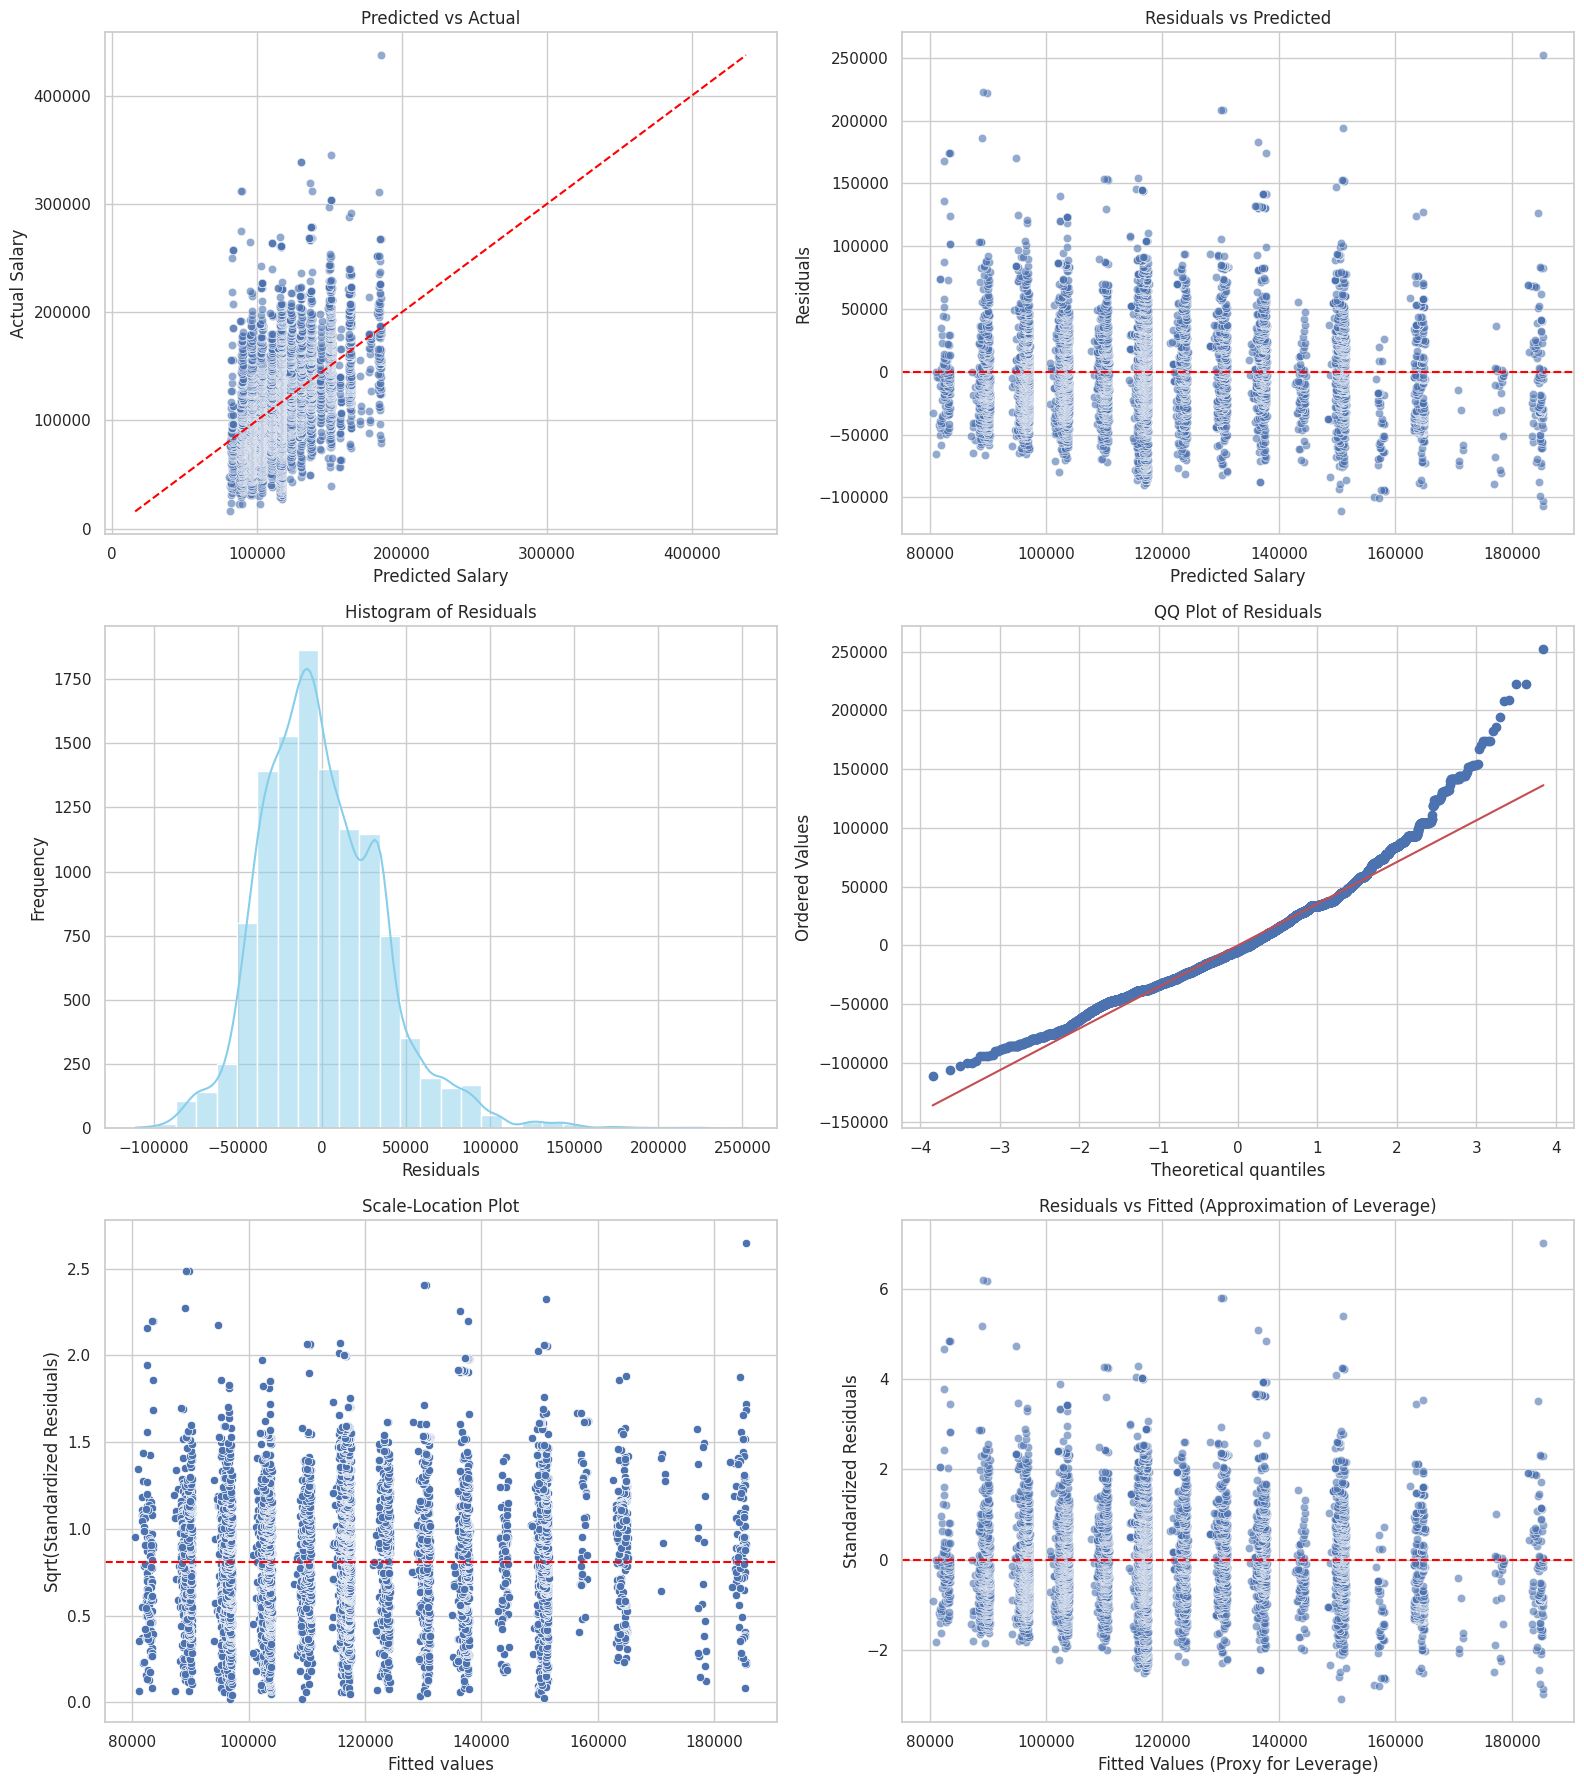

In [ ]:
#| eval: true
#| echo: false
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Load predictions from LR model
df_pred = summary.predictions.select('SALARY', 'prediction').toPandas()

# Compute residuals
df_pred['residuals'] = df_pred['SALARY'] - df_pred['prediction']
df_pred['fitted'] = df_pred['prediction']

# Standardized residuals
res_mean = df_pred['residuals'].mean()
res_std = df_pred['residuals'].std()
df_pred['std_residuals'] = (df_pred['residuals'] - res_mean) / res_std

# Square root of standardized residuals (for Scale-Location)
df_pred['sqrt_std_resid'] = np.sqrt(np.abs(df_pred['std_residuals']))


plt.figure(figsize=(16, 18))
sns.set_theme(style="whitegrid")

# Plot 1: Predicted vs Actual
plt.subplot(3, 2, 1)
sns.scatterplot(x="prediction", y="SALARY", data=df_pred, alpha=0.6)
plt.plot([df_pred["SALARY"].min(), df_pred["SALARY"].max()],
         [df_pred["SALARY"].min(), df_pred["SALARY"].max()],
         color='red', linestyle='--')
plt.title("Predicted vs Actual")
plt.xlabel("Predicted Salary")
plt.ylabel("Actual Salary")

# Plot 2: Residuals vs Predicted
plt.subplot(3, 2, 2)
sns.scatterplot(x="prediction", y="residuals", data=df_pred, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted Salary")
plt.ylabel("Residuals")

# Plot 3: Histogram of Residuals
plt.subplot(3, 2, 3)
sns.histplot(df_pred["residuals"], kde=True, bins=30, color='skyblue')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")

# Plot 4: Normal Q-Q
plt.subplot(3, 2, 4)
stats.probplot(df_pred["residuals"], dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")

# Plot 5: Scale-Location
plt.subplot(3, 2, 5)
sns.scatterplot(x="fitted", y="sqrt_std_resid", data=df_pred)
plt.axhline(y=np.mean(df_pred["sqrt_std_resid"]), color='red', linestyle='--')
plt.title("Scale-Location Plot")
plt.xlabel("Fitted values")
plt.ylabel("Sqrt(Standardized Residuals)")

# Plot 6: Residuals vs Leverage — Approximate
# Note: Leverage & Cook's Distance require X matrix; we approximate using fitted & residual
plt.subplot(3, 2, 6)
sns.scatterplot(x="fitted", y="std_residuals", data=df_pred, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Fitted (Approximation of Leverage)")
plt.xlabel("Fitted Values (Proxy for Leverage)")
plt.ylabel("Standardized Residuals")

plt.tight_layout()
plt.savefig("_output/lr_diagnostic_classic.png")
plt.show()

1. **Predicted vs Actual Plot**  
This plot assesses how well the model’s predictions align with the actual salaries. Ideally, points should lie along the red diagonal line. However, the wide spread around the line indicates that the model struggles with accurate salary prediction, especially at the lower and higher salary ranges. Most points fall below the red line, indicating a tendency to underestimate higher salaries. There's also noticeable spread, especially for salaries above $150,000, reflecting prediction inaccuracy in the upper range.

2. **Residuals vs Predicted Plot**  
This plot helps detect non-linearity and heteroscedasticity. The residuals show no clear pattern, which supports linearity. However, there's visible heteroscedasticity—residuals spread wider at higher predicted salaries, suggesting increasing variance as salary rises.

3. **Histogram of Residuals**  
The histogram shows the distribution of residuals. The histogram is slightly right-skewed but roughly centered around zero, implying minor bias and an approximately normal distribution of residuals. However, there's a longer tail on the positive side, meaning occasional large underpredictions.

4. **QQ Plot of Residuals**  
The QQ plot further assesses the normality of residuals. The residuals generally follow the diagonal line but deviate at both tails, especially the upper one. This suggests departures from normality, likely due to outliers or non-constant variance.

5. **Scale-Location Plot**  
This plot checks the homoscedasticity assumption by plotting the square root of standardized residuals. The spread of points increases slightly with fitted values, again indicating heteroscedasticity. This might impact the reliability of confidence intervals and hypothesis testing.

6. **Residuals vs Fitted (Leverage Approximation)**  
Most standardized residuals are within ±2, but a few outliers are outside that range, and there's some vertical clustering at specific fitted values. This could point to influential data points or model limitations at certain salary levels.

# Evaluation

The evaluation of the model is crucial to understand its performance. In this section, we will calculate and visualize the following metrics:
1. **R² (Coefficient of Determination)**: Indicates how well the model explains the variance in the target variable.
2. **RMSE (Root Mean Squared Error)**: Measures the average magnitude of the errors between predicted and actual values.


In [ ]:
#| eval: true
#| echo: false
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, pow, sqrt, avg, mean
import math

pred_glr = lr_model.transform(test_data)

# R²
r2_eval = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="r2")
r2 = r2_eval.evaluate(pred_glr)

# BIC calculation
n = pred_glr.count() 
k = len(lr_model.coefficients) + 1
rss = pred_glr.select(pow(col("SALARY") - col("prediction"), 2).alias("squared_error")).agg({"squared_error": "sum"}).collect()[0][0]
bic = n * math.log(rss / n) + k * math.log(n)

# RMSE manually
residuals_df = pred_glr.withColumn("residuals", col("SALARY") - col("prediction"))
rmse = math.sqrt(residuals_df.select(mean(pow(col("residuals"), 2))).first()[0])

print(f"R²: {r2:.4f}")
print(f"BIC: {bic:.2f}")
print(f"RMSE: {rmse:.2f}")

R²: 0.2649
BIC: 60010.97
RMSE: 36687.74


1. **R² (0.2649)** indicates that approximately 26.5% of the variation in salary can be explained by the features in our model. While this shows the model captures some meaningful relationships, a large portion of salary variance remains unexplained, suggesting that important predictors may be missing, such as company-specific factors, job roles, or location.

2. **RMSE (36687.74)** reflects the average prediction error in salary, measured in the same units as the target variable (USD). A high RMSE like this suggests the model struggles to make accurate predictions, likely due to nonlinear effects, noise, or outliers in the data.

3. **BIC (60010.97)** is a metric that penalizes model complexity. It helps compare models, favoring those with better fit and fewer predictors. Although useful primarily when comparing models, a relatively high BIC here reinforces the idea that our current linear model might be overly simple for capturing salary dynamics.

## Model Evaluation Plot

- Display the predicted vs actual salary plot with a red line indicating the ideal fit (y=x).
- Use `seaborn` or `matplotlib` to create the plot.
- Customize the plot with appropriate titles, labels, and legends.
- Describe the plot in a few sentences, highlighting key insights and observations.


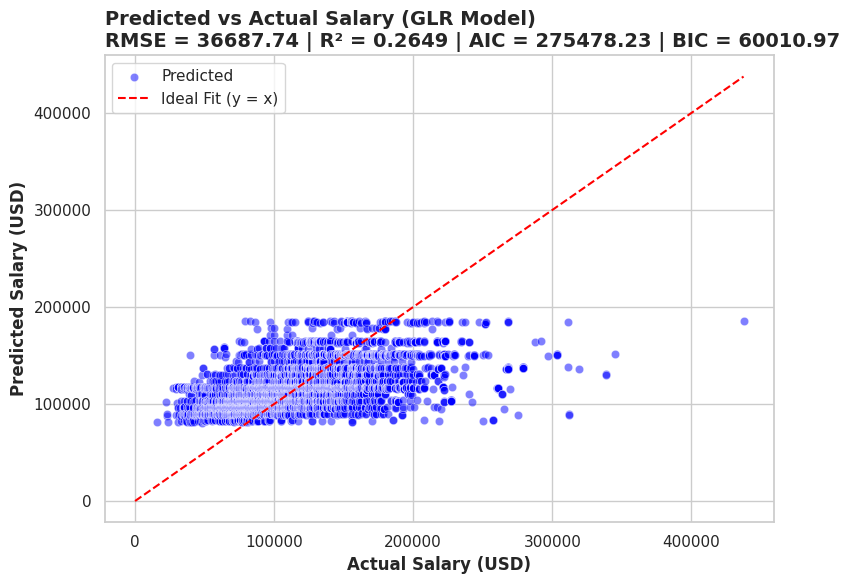

In [ ]:
#| eval: true
#| echo: false
from pyspark.ml.regression import GeneralizedLinearRegression

glr = GeneralizedLinearRegression(
    featuresCol='features',
    labelCol='SALARY',
    family="gaussian",    
    link="identity",      
    maxIter=10,
    regParam=0.1
)

glr_model = glr.fit(train_data)
summary_glr = glr_model.summary
glr_df = summary_glr.predictions.select("prediction", "SALARY").toPandas()

# Calculate RMSE
predictions = glr_model.transform(test_data)
predictions = predictions.withColumn("residual", col("SALARY") - col("prediction"))
rmse = predictions.select(mean(pow(col("residual"), 2)).alias("mse")).first()["mse"] ** 0.5

# R²
mean_y = predictions.select(mean(col("SALARY"))).first()[0]
tss = predictions.select(pow(col("SALARY") - mean_y, 2).alias("tss")).groupBy().sum("tss").first()[0]
rss = predictions.select(pow(col("residual"), 2).alias("rss")).groupBy().sum("rss").first()[0]
r2 = 1 - (rss / tss)

# AIC and BIC
aic = summary_glr.aic
n = predictions.count()
k = len(glr_model.coefficients) + 1  
bic = n * math.log(rss / n) + k * math.log(n)

# Plotting Predicted vs Actual
plt.figure(figsize=(8, 6))
sns.scatterplot(x="SALARY", y="prediction", data=glr_df, color="blue", alpha=0.5, label="Predicted")

max_val = max(glr_df["SALARY"].max(), glr_df["prediction"].max())
plt.plot([0, max_val], [0, max_val], color="red", linestyle="--", label="Ideal Fit (y = x)")

plt.title(f"Predicted vs Actual Salary (GLR Model)\n"
          f"RMSE = {rmse:.2f} | R² = {r2:.4f} | AIC = {aic:.2f} | BIC = {bic:.2f}", 
          loc="left", fontsize=14, fontweight="bold")
plt.xlabel("Actual Salary (USD)", fontsize=12, fontweight="bold")
plt.ylabel("Predicted Salary (USD)" , fontsize=12, fontweight="bold")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save figure
plt.savefig("_output/glr_predicted_vs_actual.png")
plt.show()

This plot visualizes the performance of the GLR (Generalized Linear Regression) model. The blue scatter points represent the predicted salaries versus the actual salaries in the test set, while the red dashed line illustrates the ideal scenario where predictions perfectly match actual values.

The plot indicates that predictions tend to cluster around the lower to mid salary range (predominantly under $200,000). This suggests the model performs better at estimating average salary levels but struggles with extreme values. Notable deviations from the red line are observed for higher actual salaries, reflecting the model's tendency to underestimate salaries in this range. The R² value of 0.2649 reveals that the model explains approximately 26.5% of the variance in salary, hinting at potential non-linear relationships or unaccounted factors. The RMSE of $36,687.74 signifies the typical error magnitude, while the high AIC (275,478.23) and BIC (60,010.97) underscore the model's complexity relative to its fit.

In summary, while the model demonstrates reasonable performance in predicting salaries within the central range, its accuracy diminishes significantly for high-income outliers, indicating room for improvement.

# Submission {.unnumbered}
1. Save figures in the `_output/` folder.
2. Commit and push code and output files:
```bash
git add .
git commit -m "Add Lab 08 Salary Prediction models and output"
git push origin main
```
3. Submit your GitHub repository link.

# Resources {.unnumbered}
- [PySpark MLlib Docs](https://spark.apache.org/docs/latest/ml-guide.html)  
- [Seaborn Docs](https://seaborn.pydata.org/)  
- [Pandas User Guide](https://pandas.pydata.org/docs/user_guide/index.html)
